<a href="https://colab.research.google.com/github/SergeyShchus/Automatic_GIS/blob/master/Notebook/Geopandas/Network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
# Install OpticalRS. This also installs GeoPandas because GeoPandas is a dependency of OpticalRS
!apt-get install software-properties-common python-software-properties > /dev/null
!add-apt-repository ppa:ubuntugis/ppa -y > /dev/null
!apt-get update > /dev/null
!apt-get install -y --fix-missing python-gdal gdal-bin libgdal-dev > /dev/null
!pip2 install OpticalRS > /dev/null

! pip install geopandas
!apt install libspatialindex-dev
!pip install osmnx

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from pyproj import CRS

from google.colab import drive
drive.mount('/content/gdrive')

E: Package 'python-software-properties' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 60 not upgraded.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


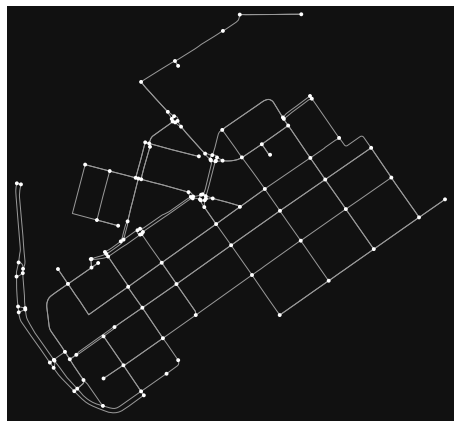

In [2]:
place_name = "Kamppi, Helsinki, Finland"
graph = ox.graph_from_place(place_name, network_type='drive')

fig, ax = ox.plot_graph(graph)

In [3]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [4]:
# Check columns
edges.columns

Index(['osmid', 'oneway', 'lanes', 'name', 'highway', 'maxspeed', 'length',
       'geometry', 'junction', 'bridge', 'access'],
      dtype='object')

In [5]:
# Check crs
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
edges.head()

osmid  ...  access
u        v          key                                                     ...        
25216594 1372425714 0                                             23856784  ...     NaN
25238874 1372425713 0                                 [29977177, 30470347]  ...     NaN
25238944 25216594   0                                 [372440330, 8135861]  ...     NaN
         319896278  0            [25514547, 677423564, 30288797, 30288799]  ...     NaN
25291537 25291591   0    [30568275, 36729015, 316590744, 316590745, 316...  ...     NaN

[5 rows x 11 columns]

In [7]:
edges['highway'].value_counts()

residential      113
tertiary          78
primary           26
secondary         17
unclassified      10
living_street      4
primary_link       1
Name: highway, dtype: int64

In [8]:
# Project the data
graph_proj = ox.project_graph(graph) 

In [9]:
# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [10]:
print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [11]:
edges_proj.head()

osmid  ...  access
u          v          key                                           ...        
25216594   1372425714 0                                   23856784  ...     NaN
1372425714 25238874   0    [78537378, 8169098, 29081876, 78537375]  ...     NaN
           1372425718 0                                   29066052  ...     NaN
25238874   1372425713 0                       [29977177, 30470347]  ...     NaN
1372425713 568147264  0                                   57839670  ...     NaN

[5 rows x 11 columns]

In [12]:
CRS(edges_proj.crs).to_epsg()

32635

In [13]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj, circuity_dist='euclidean')
stats

{'circuity_avg': 1.0244553920193706,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None,
 'edge_density_km': None,
 'edge_length_avg': 80.26797188755026,
 'edge_length_total': 19986.725000000013,
 'intersection_count': 116,
 'intersection_density_km': None,
 'k_avg': 4.016129032258065,
 'm': 249,
 'n': 124,
 'node_density_km': None,
 'self_loop_proportion': 0.0,
 'street_density_km': None,
 'street_length_avg': 74.70906557377049,
 'street_length_total': 13671.758999999998,
 'street_segments_count': 183,
 'streets_per_node_avg': 3.217741935483871,
 'streets_per_node_counts': {0: 0, 1: 8, 2: 1, 3: 71, 4: 44},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.06451612903225806,
  2: 0.008064516129032258,
  3: 0.5725806451612904,
  4: 0.3548387096774194}}

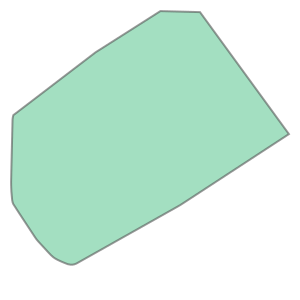

In [14]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Show output
convex_hull

In [15]:
# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True)

# Add extened statistics to the basic statistics
for key, value in extended_stats.items():
    stats[key] = value
    
# Convert the dictionary to a Pandas series for a nicer output
pd.Series(stats)

n                                                                                    124
m                                                                                    249
k_avg                                                                            4.01613
intersection_count                                                                   116
streets_per_node_avg                                                             3.21774
streets_per_node_counts                                 {0: 0, 1: 8, 2: 1, 3: 71, 4: 44}
streets_per_node_proportion            {0: 0.0, 1: 0.06451612903225806, 2: 0.00806451...
edge_length_total                                                                19986.7
edge_length_avg                                                                   80.268
street_length_total                                                              13671.8
street_length_avg                                                                74.7091
street_segments_count

In [16]:
# Set place name
place = "Maria 01, Helsinki"

In [17]:
# Geocode the place name
geocoded_place = ox.geocode_to_gdf(place)

In [18]:
# Check the result
geocoded_place

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((24.92122 60.16644, 24.92126 60.16625...",60.167525,60.16624,24.92317,24.921221,95257834,way,23856740,60.166884,24.921661,"Maria 01, Baana, Hietalahti, Kamppi, Southern ...",building,yes,0.58084


In [19]:
# Re-project 
geocoded_place.to_crs(CRS(edges_proj.crs), inplace=True)

In [20]:
# Get centroid as shapely point
origin = geocoded_place["geometry"].centroid.values[0]

In [21]:
print(origin)

POINT (384692.1788217347 6671817.486427824)


In [22]:
nodes_proj.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
25216594,6.671580e+06,384631.322372,4,24.921057,60.164794,NaN,POINT (384631.322 6671580.071)
1372425714,6.671540e+06,384624.178763,4,24.920951,60.164432,NaN,POINT (384624.179 6671539.986)
25238874,6.671454e+06,384625.787221,4,24.921028,60.163665,NaN,POINT (384625.787 6671454.380)
1372425713,6.671438e+06,384627.187049,4,24.921063,60.163516,NaN,POINT (384627.187 6671437.809)
25238944,6.671562e+06,384643.473274,3,24.921286,60.164631,NaN,POINT (384643.473 6671561.534)


In [23]:
# Retrieve the maximum x value (i.e. the most eastern)
maxx = nodes_proj['x'].max()

In [24]:
# Easternmost point
destination = nodes_proj.loc[nodes_proj['x']==maxx, 'geometry'].values[0]
print(destination)

POINT (385855.0300992894 6671721.810323974)


In [25]:
# Get origin x and y coordinates
orig_xy = (origin.y, origin.x)

# Get target x and y coordinates
target_xy = (destination.y, destination.x)

In [26]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node_id = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')
orig_node_id

319896278

In [27]:
# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node_id = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')
target_node_id

317703609

In [28]:
# Retrieve the rows from the nodes GeoDataFrame based on the node id (node id is the index label)
orig_node = nodes_proj.loc[orig_node_id]
target_node = nodes_proj.loc[target_node_id]

In [29]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([orig_node, target_node], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

,y,x,street_count,lon,lat,highway,geometry
319896278,6.671803e+06,384645.074633,3,24.921178,60.166794,NaN,POINT (384645.075 6671802.525)
317703609,6.671722e+06,385855.030099,2,24.943012,60.166410,traffic_signals,POINT (385855.030 6671721.810)


In [30]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node_id, target=target_node_id, weight='length')

# Show what we have
print(route)

[319896278, 1382320455, 25216594, 1372425714, 25238874, 1372425713, 529507771, 258188404, 1372318829, 159619609, 175832743, 1372425705, 1007980689, 149143065, 268177652, 60004721, 1372376937, 1372441170, 60170471, 1377211668, 1377211666, 25291565, 25291564, 317703609]


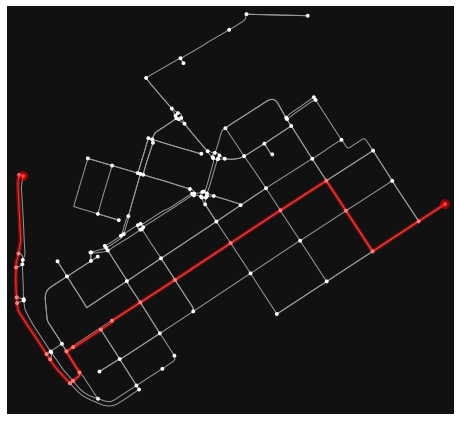

In [32]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route)

In [33]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]
route_nodes

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
319896278,6.671803e+06,384645.074633,3,24.921178,60.166794,NaN,POINT (384645.075 6671802.525)
1382320455,6.671806e+06,384633.394361,4,24.920966,60.166820,NaN,POINT (384633.394 6671805.824)
25216594,6.671580e+06,384631.322372,4,24.921057,60.164794,NaN,POINT (384631.322 6671580.071)
1372425714,6.671540e+06,384624.178763,4,24.920951,60.164432,NaN,POINT (384624.179 6671539.986)
25238874,6.671454e+06,384625.787221,4,24.921028,60.163665,NaN,POINT (384625.787 6671454.380)
1372425713,6.671438e+06,384627.187049,4,24.921063,60.163516,NaN,POINT (384627.187 6671437.809)
529507771,6.671292e+06,384711.598018,4,24.922665,60.162230,NaN,POINT (384711.598 6671291.757)
258188404,6.671276e+06,384721.946323,4,24.922860,60.162095,NaN,POINT (384721.946 6671276.431)
1372318829,6.671208e+06,384778.761107,3,24.923922,60.161496,NaN,POINT (384778.761 6671207.956)


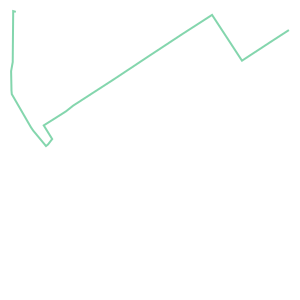

In [34]:
from shapely.geometry import LineString, Point

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes.geometry.values))
route_line

In [39]:
route_nodes.columns

Index(['y', 'x', 'street_count', 'lon', 'lat', 'highway', 'geometry'], dtype='object')

In [40]:
route_nodes.reset_index (inplace = True)
route_nodes.columns

Index(['osmid', 'y', 'x', 'street_count', 'lon', 'lat', 'highway', 'geometry'], dtype='object')

In [41]:
# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Add a list of osmids associated with the route
route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

# Calculate the route length
route_geom['length_m'] = route_geom.length

route_geom.head()

,geometry,osmids,length_m
0,"LINESTRING (384645.075 6671802.525, 384633.394...","[319896278, 1382320455, 25216594, 1372425714, ...",2152.495705


In [42]:
tags = {'building': True}
buildings = ox.geometries_from_place(place_name, tags)

In [43]:
buildings_proj = buildings.to_crs(CRS(edges_proj.crs))

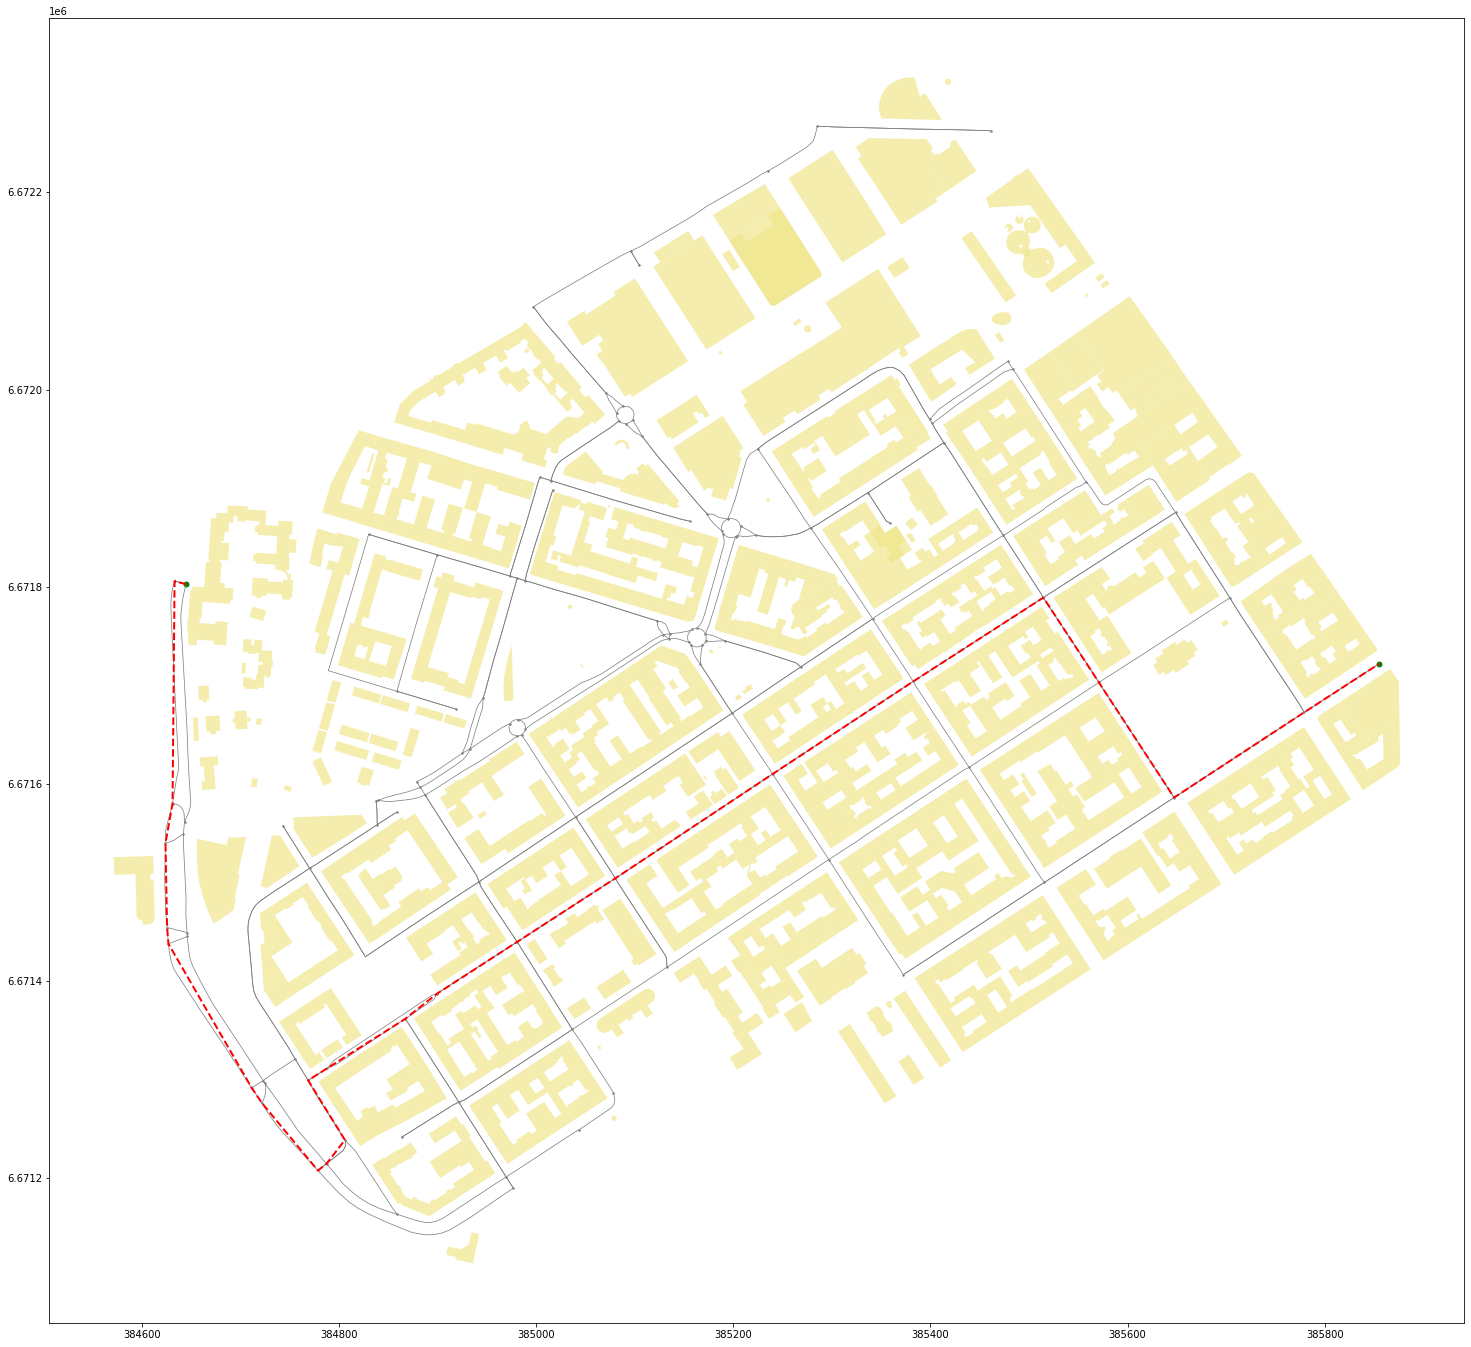

In [46]:
# Plot edges and nodes
ax = edges_proj.plot(linewidth=0.75, color='gray', figsize=(36,24))
ax = nodes_proj.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings_proj.plot(ax=ax, facecolor='khaki', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add the origin and destination nodes of the route
ax = od_nodes.plot(ax=ax, markersize=24, color='green')

In [47]:
# Columns with invalid values
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid']

# Iterate over invalid columns and convert them to string format
for col in invalid_cols:
    edges_proj[col] = edges_proj[col].astype(str)
    
print(edges_proj.dtypes)

osmid         object
oneway        object
lanes         object
name          object
highway       object
maxspeed      object
length       float64
geometry    geometry
bridge        object
junction      object
access        object
dtype: object


In [54]:
import os

# Parse the place name for the output file names (replace spaces with underscores and remove commas)
place_name_out = place_name.replace(' ', '_').replace(',','')

# Output directory
out_dir = '/content/temp'

# Parse output file paths
streets_out = os.path.join(out_dir, "%s_streets.shp" % place_name_out)
route_out = os.path.join(out_dir, "Route_from_a_to_b_at_%s.shp" % place_name_out)
nodes_out = os.path.join(out_dir, "%s_nodes.shp" % place_name_out)
buildings_out = os.path.join(out_dir, "%s_buildings.shp" % place_name_out)
od_out = os.path.join(out_dir, "%s_route_OD_points.shp" % place_name_out)

# Save files
edges_proj.to_file(streets_out)
route_geom.to_file(route_out)
nodes_proj.to_file(nodes_out)
od_nodes.to_file(od_out)
buildings[['geometry', 'name', 'addr:street']].to_file(buildings_out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
